In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

In [9]:
data = pd.read_csv("house_prices_selection.csv")

In [10]:
data.shape

(1460, 32)

In [11]:
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
boolean_features = data.select_dtypes(include=['bool']).columns.tolist()

if 'SalePrice' in numerical_features:
    numerical_features.remove('SalePrice')

for cols in boolean_features:
    data[cols] = data[cols].astype(int)
numerical_features.extend(boolean_features)

In [12]:
print(f"Coloane numerice ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")

Coloane numerice (26): ['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'MSZoning_RL', 'LotConfig_CulDSac', 'LandContour_HLS', 'LotShape_IR2', 'Condition1_Norm', 'Condition1_Feedr', 'LotShape_Reg', 'MSZoning_RM']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']


In [13]:
df_dropna = data.dropna()
print("Shape after dropna:", df_dropna.shape)

Shape after dropna: (1164, 32)


In [14]:
X = df_dropna.drop("SalePrice", axis=1)
y = df_dropna["SalePrice"]

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
preprocessor_dropna = ColumnTransformer([
    ("num", "passthrough", [col for col in numerical_features if col != "SalePrice"]),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

pipe_dropna = Pipeline([
    ("prep", preprocessor_dropna),
    ("model", LinearRegression())
])

In [16]:
pipe_dropna.fit(X_train_A, y_train_A)
y_pred_A = pipe_dropna.predict(X_test_A)

rmse_A =np.sqrt(mean_squared_error(y_test_A, y_pred_A))

print("RMSE (dropna):", rmse_A)

RMSE (dropna): 35344.636999656526


In [17]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_imputer = ColumnTransformer([
    ("num", numeric_transformer, [col for col in numerical_features if col != "SalePrice"]),
    ("cat", categorical_transformer, categorical_features)
])

pipe_imputer = Pipeline([
    ("prep", preprocessor_imputer),
    ("model", LinearRegression())
])

In [19]:
pipe_imputer.fit(X_train_B, y_train_B)
y_pred_B = pipe_imputer.predict(X_test_B)

rmse_B = np.sqrt(mean_squared_error(y_test_B, y_pred_B))

print("RMSE (with SimpleImputer):", rmse_B)

RMSE (with SimpleImputer): 34363.9051820428


In [20]:
print("Dropna RMSE:        ", rmse_A)
print("SimpleImputer RMSE: ", rmse_B)

Dropna RMSE:         35344.636999656526
SimpleImputer RMSE:  34363.9051820428


Using SimpleImputer preserved all data and produced better predictive performance.

Therefore, imputing missing values is the better preprocessing strategy for this dataset.

**Cerinta 18-Nov**

In [21]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

In [22]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
pipe_lr = Pipeline([
    ("prep", preprocessor),
    ("regressor", LinearRegression())
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print(f"Rezultat LR")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

Rezultat LR
MAE: 21,924.28
RMSE: 34,363.91
R² Score: 0.8460


In [24]:
results = {}
results["linear_regression"] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

In [25]:
param_grid_dt = {
    'regressor__max_depth': [None, 5, 10, 15, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4, 8],
    'regressor__max_features': ['sqrt', 'log2', None],
    'regressor__criterion': ['squared_error', 'friedman_mse']
}

In [26]:
pipe_dt = Pipeline([
    ("prep", preprocessor),
    ("regressor", DecisionTreeRegressor(random_state=42))
])

grid_dt = GridSearchCV(
    pipe_dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['EVI',
                                                                          'ZoningScore',
                                                                          'Price_per_m^2',
                                                                          'PDI',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'WoodDeckSF',
                                                                          'OpenPorchSF',
                                                                          'FullBath',
                                                                          'GarageCars',
                                                                          'GarageArea',
                                                                          'OverallQual',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'GrLivArea'...
                                                                          'Foundation'])])),
                                       ('regressor',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__criterion': ['squared_error',
                                                  'friedman_mse'],
                         'regressor__max_depth': [None, 5, 10, 15, 20],
                         'regressor__max_features': ['sqrt', 'log2', None],
                         'regressor__min_samples_leaf': [1, 2, 4, 8],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [27]:
y_pred_dt = grid_dt.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_dt)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2 = r2_score(y_test, y_pred_dt)

print(f"Rezultat LR")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")
grid_dt.best_params_

Rezultat LR
MAE: 21,075.37
RMSE: 32,031.42
R² Score: 0.8662


{'regressor__criterion': 'squared_error',
 'regressor__max_depth': 10,
 'regressor__max_features': None,
 'regressor__min_samples_leaf': 4,
 'regressor__min_samples_split': 10}

In [28]:
results["decision_tree"] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

In [29]:
param_grid_rf = {
    'regressor__n_estimators': [100, 300],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__min_samples_split': [2, 5],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__bootstrap': [True]
}

In [30]:
pipe_rf = Pipeline([
    ("prep", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    cv=3,   # reduce to 3 to save time
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['EVI',
                                                                          'ZoningScore',
                                                                          'Price_per_m^2',
                                                                          'PDI',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'WoodDeckSF',
                                                                          'OpenPorchSF',
                                                                          'FullBath',
                                                                          'GarageCars',
                                                                          'GarageArea',
                                                                          'OverallQual',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'GrLivArea'...
                                                                          'CentralAir',
                                                                          'Foundation'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__bootstrap': [True],
                         'regressor__max_depth': [10, 20, None],
                         'regressor__max_features': ['sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 300]},
             scoring='neg_mean_squared_error')

In [31]:
y_pred_rf = grid_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print(f"Rezultat RF")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")


results["random_forest"] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

Rezultat RF
MAE: 16,747.99
RMSE: 28,016.65
R² Score: 0.8977


In [32]:
grid_rf.best_params_

{'regressor__bootstrap': True,
 'regressor__max_depth': None,
 'regressor__max_features': 'log2',
 'regressor__min_samples_leaf': 1,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 100}

In [33]:
results

{'linear_regression': {'MAE': 21924.279794299066,
  'RMSE': np.float64(34363.9051820428),
  'R2': 0.8460459245848057},
 'decision_tree': {'MAE': 21075.366571307917,
  'RMSE': np.float64(32031.42192714047),
  'R2': 0.8662361987012862},
 'random_forest': {'MAE': 16747.98852739726,
  'RMSE': np.float64(28016.64816112911),
  'R2': 0.8976663373913597}}

Random Forest performs best
* Lowest error (MAE, RMSE)
* Highest R²
* Most robust and least sensitive to noise

Decision Tree improves over Linear Regression
* Learns nonlinear splits
* But limited without ensembles → still less stable than RF

Linear Regression weakest model
* Assumes linear relationships
* Cannot capture complex interactions like quality × area

**19-Nov**

In [34]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [35]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [36]:
preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), numerical_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_features)
])

In [37]:
models = {
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="rmse",
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        random_state=42
    )
}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("regressor", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    }


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2738
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 43
[LightGBM] [Info] Start training from score 181441.541952


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [38]:
for col in categorical_features:
    X_train[col] = X_train[col].fillna("missing")
    X_test[col] = X_test[col].fillna("missing")

In [39]:
catboost_model = CatBoostRegressor(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function="RMSE",
    verbose=False,
    random_state=42
)

cat_model = CatBoostRegressor(verbose=False)
cat_features_idx = [X.columns.get_loc(col) for col in categorical_features]

catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features_idx
)

preds_cat = catboost_model.predict(X_test)

results["CatBoost"] = {
    "MAE": mean_absolute_error(y_test, preds_cat),
    "RMSE": np.sqrt(mean_squared_error(y_test, preds_cat)),
    "R2": r2_score(y_test, preds_cat)
}

In [40]:
results

{'linear_regression': {'MAE': 21924.279794299066,
  'RMSE': np.float64(34363.9051820428),
  'R2': 0.8460459245848057},
 'decision_tree': {'MAE': 21075.366571307917,
  'RMSE': np.float64(32031.42192714047),
  'R2': 0.8662361987012862},
 'random_forest': {'MAE': 16747.98852739726,
  'RMSE': np.float64(28016.64816112911),
  'R2': 0.8976663373913597},
 'XGBoost': {'MAE': 11314.7001953125,
  'RMSE': np.float64(18863.664967338664),
  'R2': 0.953608512878418},
 'LightGBM': {'MAE': 11598.311482789413,
  'RMSE': np.float64(21923.336007510472),
  'R2': 0.9373386934641905},
 'CatBoost': {'MAE': 11367.229382487683,
  'RMSE': np.float64(18978.219741523215),
  'R2': 0.9530433498095481}}

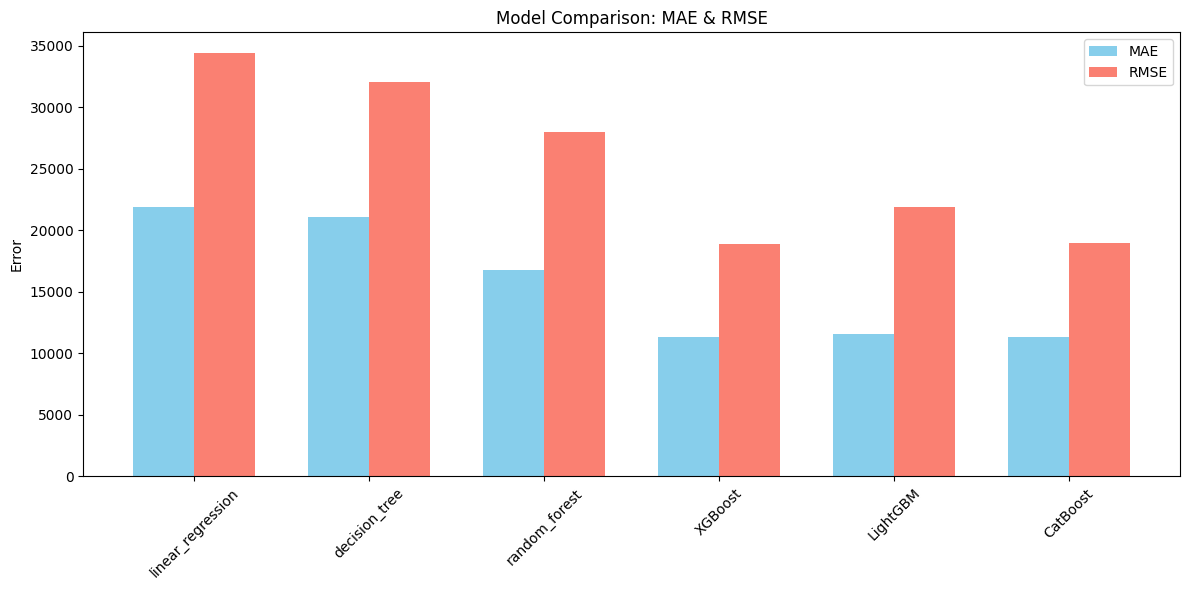

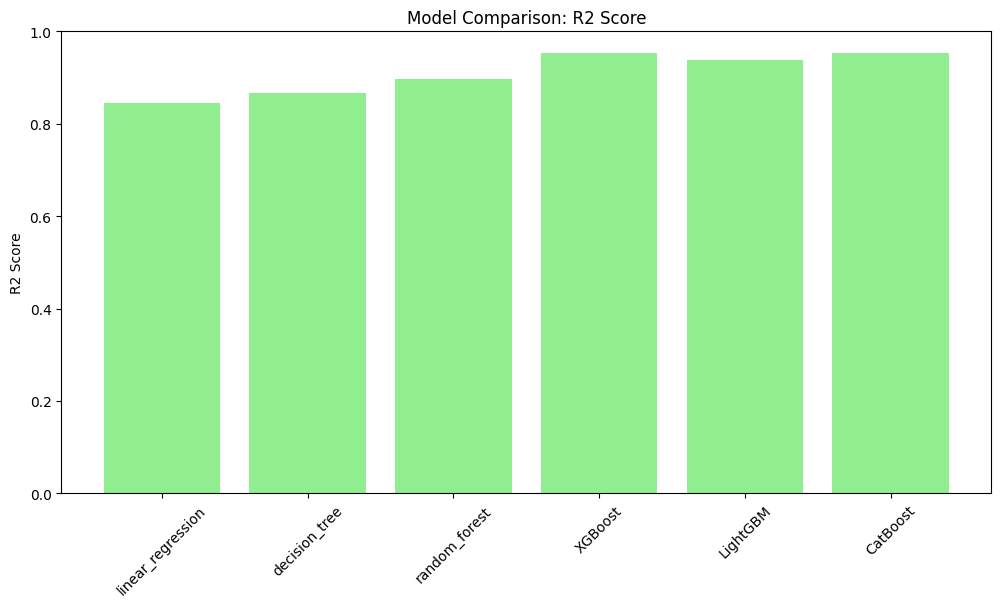

In [43]:
models_graph = list(results.keys())
mae = [results[m]['MAE'] for m in models_graph]
rmse = [results[m]['RMSE'] for m in models_graph]
r2 = [results[m]['R2'] for m in models_graph]

# Plot MAE and RMSE together
x = np.arange(len(models_graph))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(x - width/2, mae, width, label='MAE', color='skyblue')
ax1.bar(x + width/2, rmse, width, label='RMSE', color='salmon')
ax1.set_ylabel('Error')
ax1.set_xticks(x)
ax1.set_xticklabels(models_graph, rotation=45)
ax1.set_title('Model Comparison: MAE & RMSE')
ax1.legend()

plt.tight_layout()
plt.show()

# Plot R2 separately
plt.figure(figsize=(12,6))
plt.bar(models_graph, r2, color='lightgreen')
plt.ylabel('R2 Score')
plt.title('Model Comparison: R2 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

Cerinta 27-Nov

In [44]:
param_xgb = {
    "regressor__n_estimators": [300, 500, 800],
    "regressor__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "regressor__max_depth": [3, 5, 7, 9],
    "regressor__subsample": [0.6, 0.8, 1.0],
    "regressor__colsample_bytree": [0.6, 0.8, 1.0]
}


In [45]:
param_lgbm = {
    "regressor__n_estimators": [300, 500, 800],
    "regressor__learning_rate": [0.01, 0.05, 0.1],
    "regressor__num_leaves": [31, 50, 70],
    "regressor__max_depth": [-1, 5, 10]
}

In [46]:
param_cat = {
    "iterations": [300, 500, 800],
    "depth": [6, 8, 10],
    "learning_rate": [0.01, 0.03, 0.05, 0.1]
}

In [48]:
from sklearn.model_selection import RandomizedSearchCV
pipe_xgb = Pipeline([
    ("preprocess", preprocess),
    ("regressor", models["XGBoost"])
])

search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_xgb,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search_xgb.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['EVI',
                                                                                'ZoningScore',
                                                                                'Price_per_m^2',
                                                                                'PDI',
                                                                                'LotFrontage',
                                                                                'LotArea',
                                                                                'WoodDeckSF',
                                                                                'OpenPorchSF',
                                                                                'FullBath',
                                                                                'GarageCars',
                                                                                'GarageArea',
                                                                                'OverallQual',
                                                                                'YearBuilt',
                                                                                'YearRemodAdd',
                                                                                'MasVnrArea',
                                                                                'GrLivArea',
                                                                                'TotalBsmtSF',
                                                                                '1s...
                                                           n_jobs=None,
                                                           num_parallel_tree=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'regressor__colsample_bytree': [0.6,
                                                                        0.8,
                                                                        1.0],
                                        'regressor__learning_rate': [0.01, 0.03,
                                                                     0.05,
                                                                     0.1],
                                        'regressor__max_depth': [3, 5, 7, 9],
                                        'regressor__n_estimators': [300, 500,
                                                                    800],
                                        'regressor__subsample': [0.6, 0.8,
                                                                 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [49]:
pipe_lgbm = Pipeline([
    ("preprocess", preprocess),
    ("regressor", models["LightGBM"])
])

search_lgbm = RandomizedSearchCV(
    estimator=pipe_lgbm,
    param_distributions=param_lgbm,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search_lgbm.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 43
[LightGBM] [Info] Start training from score 180921.195890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['EVI',
                                                                                'ZoningScore',
                                                                                'Price_per_m^2',
                                                                                'PDI',
                                                                                'LotFrontage',
                                                                                'LotArea',
                                                                                'WoodDeckSF',
                                                                                'OpenPorchSF',
                                                                                'FullBath',
                                                                                'GarageCars',
                                                                                'GarageArea',
                                                                                'OverallQual',
                                                                                'YearBuilt',
                                                                                'YearRemodAdd',
                                                                                'MasVnrArea',
                                                                                'GrLivArea',
                                                                                'TotalBsmtSF',
                                                                                '1s...
                                                                                'Foundation'])])),
                                             ('regressor',
                                              LGBMRegressor(learning_rate=0.05,
                                                            n_estimators=500,
                                                            random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'regressor__learning_rate': [0.01, 0.05,
                                                                     0.1],
                                        'regressor__max_depth': [-1, 5, 10],
                                        'regressor__n_estimators': [300, 500,
                                                                    800],
                                        'regressor__num_leaves': [31, 50, 70]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [50]:
from catboost import CatBoostRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np

best_rmse_cat = float("inf")
best_params_cat = None

for params in ParameterGrid(param_cat):
    model = CatBoostRegressor(
        verbose=False,
        random_state=42,
        **params
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_features_idx
    )

    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    if rmse < best_rmse_cat:
        best_rmse_cat = rmse
        best_params_cat = params

In [51]:
final_results = {
    "XGBoost": {
        "Best RMSE": -search_xgb.best_score_,
        "Best Params": search_xgb.best_params_
    },
    "LightGBM": {
        "Best RMSE": -search_lgbm.best_score_,
        "Best Params": search_lgbm.best_params_
    },
    "CatBoost": {
        "Best RMSE": best_rmse_cat,
        "Best Params": best_params_cat
    }
}

In [52]:
final_results

{'XGBoost': {'Best RMSE': np.float64(19819.7353515625),
  'Best Params': {'regressor__subsample': 0.6,
   'regressor__n_estimators': 800,
   'regressor__max_depth': 5,
   'regressor__learning_rate': 0.03,
   'regressor__colsample_bytree': 0.8}},
 'LightGBM': {'Best RMSE': np.float64(19865.52116676516),
  'Best Params': {'regressor__num_leaves': 50,
   'regressor__n_estimators': 800,
   'regressor__max_depth': 5,
   'regressor__learning_rate': 0.1}},
 'CatBoost': {'Best RMSE': np.float64(16671.78622899706),
  'Best Params': {'depth': 6, 'iterations': 800, 'learning_rate': 0.1}}}

XGBoost and LightGBM performed very similarly, XGBoost wins by a small margin.

CatBoost is the best model by a large margin, with the best configuration being:

iterations = 800

depth = 6

learning_rate = 0.1

Cerinta 28-Nov

In [53]:
from sklearn.model_selection import train_test_split

# First split: 60% train vs 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Second split: 20% validation, 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

X_train.shape, X_val.shape, X_test.shape

((876, 31), (292, 31), (292, 31))

In [54]:
preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), numerical_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_features)
])

In [55]:
models = {
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="rmse",
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=800,
        learning_rate=0.01,
        random_state=42
    ),
    "CatBoost": CatBoostRegressor(
        iterations=800,
        depth=6,
        learning_rate=0.01,
        loss_function="RMSE",
        verbose=False,
        random_state=42
    )
}

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

validation_results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("regressor", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)

    validation_results[name] = {
        "MAE": mean_absolute_error(y_val, preds),
        "RMSE": np.sqrt(mean_squared_error(y_val, preds)),
        "R2": r2_score(y_val, preds)
    }

validation_results

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2621
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 41
[LightGBM] [Info] Start training from score 179921.786530
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'XGBoost': {'MAE': 13926.830078125,
  'RMSE': np.float64(24010.61098764461),
  'R2': 0.9387814402580261},
 'LightGBM': {'MAE': 15740.472914817463,
  'RMSE': np.float64(32681.12737445153),
  'R2': 0.8865849409703552},
 'CatBoost': {'MAE': 16894.50864240162,
  'RMSE': np.float64(31280.17372198139),
  'R2': 0.8961001365913501}}

In [57]:
best_model_name = min(validation_results, key=lambda m: validation_results[m]["RMSE"])
best_model_name

'XGBoost'

In [58]:
# Combine train + validation
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

best_model = models[best_model_name]

pipeline_final = Pipeline([
    ("preprocess", preprocess),
    ("regressor", best_model)
])

pipeline_final.fit(X_train_full, y_train_full)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['EVI', 'ZoningScore',
                                                   'Price_per_m^2', 'PDI',
                                                   'LotFrontage', 'LotArea',
                                                   'WoodDeckSF', 'OpenPorchSF',
                                                   'FullBath', 'GarageCars',
                                                   'GarageArea', 'OverallQual',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'GrLivArea',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   'MSZoning_RL',
                                                   'LotConfig_C...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [59]:
final_preds = pipeline_final.predict(X_test)

final_results = {
    "MAE": mean_absolute_error(y_test, final_preds),
    "RMSE": np.sqrt(mean_squared_error(y_test, final_preds)),
    "R2": r2_score(y_test, final_preds)
}

final_results


{'MAE': 10714.43359375,
 'RMSE': np.float64(16439.059827131234),
 'R2': 0.9447423219680786}

So XGBoost was the best model for validation in this case. It was good also on the test subset, with the scores improving. No signs of overfitting, XGBoost generalizes very well.

Cerinta 2-Dec

In [66]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

In [67]:
xgb_base = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_base = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

cat_base = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    verbose=False,
    random_state=42
)

dt_base = DecisionTreeRegressor(random_state=42)
rf_base = RandomForestRegressor(random_state=42)
lin_base = LinearRegression()

In [76]:
stackA = StackingRegressor(
    estimators=[
        ("xgb", xgb_base),
        ("cat", cat_base),
        ("lgbm", lgbm_base)
    ],
    final_estimator=lin_base,
    cv=5
)

pipeline_stack1 = Pipeline([("preprocess", preprocessor), ("model", stackA)])
r2_stack1 = cross_val_score(pipeline_stack1, X, y, cv=5, scoring="r2").mean()
print(f"R² = {r2_stack1:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 43
[LightGBM] [Info] Start training from score 180717.091610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2640
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 179921.700214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2628
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 179712.740899


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2624
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 181150.592077


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2630
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 182164.335829


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2629
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 180634.627807


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 42
[LightGBM] [Info] Start training from score 180407.575342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 180109.922912


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2633
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 179137.457173


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 180763.531049


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 181777.688770


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2638
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 180247.980749


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 43
[LightGBM] [Info] Start training from score 180007.375000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2622
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 40
[LightGBM] [Info] Start training from score 179609.458244


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2632
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 40
[LightGBM] [Info] Start training from score 179561.935760


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 179838.587794


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2660
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 181277.759358


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2624
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 179748.051337


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2742
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 42
[LightGBM] [Info] Start training from score 182883.660103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 183206.354390


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2664
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 183158.831906


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2662
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 181875.518201


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2669
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 182836.056684


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2662
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 183341.100535


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 42
[LightGBM] [Info] Start training from score 180590.277397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2621
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 180338.398287


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2631
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 180290.875803


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 179007.562099


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2624
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 180434.872727


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 182877.395722
R² = 0.9310


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [77]:
stackB = StackingRegressor(
    estimators=[
        ("xgb", xgb_base),
        ("cat", cat_base),
        ("rf", rf_base)
    ],
    final_estimator=lgbm_base,
    cv=5
)


pipeline_stack2 = Pipeline([("preprocess", preprocessor), ("model", stackB)])
r2_stack1 = cross_val_score(pipeline_stack2, X, y, cv=5, scoring="r2").mean()
print(f"R² = {r2_stack1:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 3
[LightGBM] [Info] Start training from score 180717.091610


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 3
[LightGBM] [Info] Start training from score 180407.575342


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 3
[LightGBM] [Info] Start training from score 180007.375000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 3
[LightGBM] [Info] Start training from score 182883.660103


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 3
[LightGBM] [Info] Start training from score 180590.277397
R² = 0.9007


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [78]:
stackC = StackingRegressor(
    estimators=[
        ("xgb", xgb_base),
        ("lgbm", lgbm_base),
    ],
    final_estimator=cat_base,
    cv=5
)

pipeline_stack3 = Pipeline([("preprocess", preprocessor), ("model", stackC)])
r2_stack1 = cross_val_score(pipeline_stack3, X, y, cv=5, scoring="r2").mean()
print(f"R² = {r2_stack1:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 43
[LightGBM] [Info] Start training from score 180717.091610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2640
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 179921.700214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2628
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 179712.740899


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2624
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 181150.592077


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2630
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 182164.335829


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2629
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 180634.627807


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 42
[LightGBM] [Info] Start training from score 180407.575342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 180109.922912


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2633
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 179137.457173


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 180763.531049


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 181777.688770


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2638
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 180247.980749


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 43
[LightGBM] [Info] Start training from score 180007.375000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2622
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 40
[LightGBM] [Info] Start training from score 179609.458244


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2632
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 40
[LightGBM] [Info] Start training from score 179561.935760


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 179838.587794


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2660
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 181277.759358


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2624
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 179748.051337


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2742
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 42
[LightGBM] [Info] Start training from score 182883.660103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 183206.354390


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2664
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 183158.831906


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2662
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 181875.518201


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2669
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 182836.056684


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2662
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 183341.100535


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 42
[LightGBM] [Info] Start training from score 180590.277397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2621
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 180338.398287


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2631
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 180290.875803


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 179007.562099


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2624
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 180434.872727


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 182877.395722


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


R² = 0.9114


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [79]:
stackD = StackingRegressor(
    estimators=[
        ("rf", rf_base),
        ("lgbm", lgbm_base),
        ("lin", lin_base)
    ],
    final_estimator=xgb_base,
    cv=5
)

pipeline_stack4 = Pipeline([("preprocess", preprocessor), ("model", stackD)])
r2_stack1 = cross_val_score(pipeline_stack4, X, y, cv=5, scoring="r2").mean()
print(f"R² = {r2_stack1:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 43
[LightGBM] [Info] Start training from score 180717.091610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2640
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 179921.700214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2628
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 179712.740899


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2624
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 181150.592077


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2630
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 182164.335829


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2629
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 180634.627807


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 42
[LightGBM] [Info] Start training from score 180407.575342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 180109.922912


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2633
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 179137.457173


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 180763.531049


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 181777.688770


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2638
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 42
[LightGBM] [Info] Start training from score 180247.980749


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 43
[LightGBM] [Info] Start training from score 180007.375000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2622
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 40
[LightGBM] [Info] Start training from score 179609.458244


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2632
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 40
[LightGBM] [Info] Start training from score 179561.935760


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 179838.587794


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2660
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 181277.759358


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2624
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 179748.051337


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2742
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 42
[LightGBM] [Info] Start training from score 182883.660103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 183206.354390


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2664
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 183158.831906


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2662
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 42
[LightGBM] [Info] Start training from score 181875.518201


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2669
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 182836.056684


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2662
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 183341.100535


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 42
[LightGBM] [Info] Start training from score 180590.277397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2621
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 180338.398287


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2631
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 180290.875803


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 179007.562099


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2624
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 180434.872727


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 182877.395722


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


R² = 0.8884


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Stack A got the highest score.

In [81]:
best_stack= stackA
pipeline_stack = Pipeline([
    ("preprocess", preprocess),
    ("model", best_stack)
])

In [86]:
param_dist = {
    # XGBoost
    "model__xgb__n_estimators": [200, 400, 600],
    "model__xgb__learning_rate": [0.01, 0.05, 0.1],
    "model__xgb__max_depth": [3, 5, 7],
    "model__xgb__subsample": [0.7, 0.85, 1.0],
    "model__xgb__colsample_bytree": [0.7, 0.85, 1.0],

    # LightGBM
    "model__lgbm__n_estimators": [200, 400, 600],
    "model__lgbm__learning_rate": [0.01, 0.05, 0.1],
    "model__lgbm__num_leaves": [31, 50, 70],
    "model__lgbm__max_depth": [-1, 5, 10],

    # CatBoost
    "model__cat__iterations": [200, 400, 600],
    "model__cat__depth": [6, 8, 10],
    "model__cat__learning_rate": [0.01, 0.05, 0.1]
}


In [87]:
stack = RandomizedSearchCV(
    estimator=pipeline_stack,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="r2",
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [97]:
stack.fit(X_train_full, y_train_full)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2738
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 43
[LightGBM] [Info] Start training from score 182966.458904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2658
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 40
[LightGBM] [Info] Start training from score 183978.056745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 41
[LightGBM] [Info] Start training from score 183721.694861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2654
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 181568.411765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 41
[LightGBM] [Info] Start training from score 181945.162567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['EVI',
                                                                                'ZoningScore',
                                                                                'Price_per_m^2',
                                                                                'PDI',
                                                                                'LotFrontage',
                                                                                'LotArea',
                                                                                'WoodDeckSF',
                                                                                'OpenPorchSF',
                                                                                'FullBath',
                                                                                'GarageCars',
                                                                                'GarageArea',
                                                                                'OverallQual',
                                                                                'YearBuilt',
                                                                                'YearRemodAdd',
                                                                                'MasVnrArea',
                                                                                'GrLivArea',
                                                                                'TotalBsmtSF',
                                                                                '1s...
                                        'model__lgbm__max_depth': [-1, 5, 10],
                                        'model__lgbm__n_estimators': [200, 400,
                                                                      600],
                                        'model__lgbm__num_leaves': [31, 50, 70],
                                        'model__xgb__colsample_bytree': [0.7,
                                                                         0.85,
                                                                         1.0],
                                        'model__xgb__learning_rate': [0.01,
                                                                      0.05,
                                                                      0.1],
                                        'model__xgb__max_depth': [3, 5, 7],
                                        'model__xgb__n_estimators': [200, 400,
                                                                     600],
                                        'model__xgb__subsample': [0.7, 0.85,
                                                                  1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [98]:
best_stack_tuned = stack.best_estimator_

In [99]:
print(stack.best_params_)

{'model__xgb__subsample': 1.0, 'model__xgb__n_estimators': 400, 'model__xgb__max_depth': 3, 'model__xgb__learning_rate': 0.1, 'model__xgb__colsample_bytree': 0.85, 'model__lgbm__num_leaves': 50, 'model__lgbm__n_estimators': 400, 'model__lgbm__max_depth': 5, 'model__lgbm__learning_rate': 0.01, 'model__cat__learning_rate': 0.05, 'model__cat__iterations': 400, 'model__cat__depth': 8}


In [102]:
pred_test = best_stack_tuned.predict(X_val)
r2_test = r2_score(y_val, pred_test)
print(f"Test(20%) R² after tuning: {r2_test:.4f}")

Test(20%) R² after tuning: 0.9831


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
